### 隨機森林進行選股回測 - 以財報資料處理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import datetime
from pandas.tseries.offsets import BMonthEnd
from pandas.tseries.offsets import MonthEnd

> 將日期往前挪到最近一次的工作天(因為有些財報會在星期天發布，需要做調整)

In [2]:
def move_to_nearest_working_day(date):
    if pd.isna(date):
        return date
    # 將日期轉換為 numpy datetime64[D] 格式
    date = np.datetime64(date, 'D')
    # 如果日期是工作天，則不改變
    if date.astype('datetime64[D]').astype('int') % 7 < 5:  # 確認是否為週一至週五
        return date
    else:
        # 如果是週六或週日，調整到最近的工作日（通常向前到週五）
        return np.busday_offset(date, 0, roll='backward')


#### Step1.先讀取每日報酬率(已轉換成累積一季的結果)

In [3]:
Ret_DataFrame = pd.read_pickle('持有一季報酬率(日資料表示).pkl')
Ret_DataFrame

,證券代碼,年月日,累積季報酬率
0,1101,20121210,0.062671
1,1101,20121211,0.059946
2,1101,20121212,0.086352
3,1101,20121213,0.086231
4,1101,20121214,0.107801
...,...,...,...
2515398,9958,20240624,0.439821
2515399,9958,20240625,0.469523
2515400,9958,20240626,0.490947
2515401,9958,20240627,0.487411


> 記得轉換日期，把ret_date整理成方便閱讀

In [4]:
Ret_DataFrame['年月日'] = pd.to_datetime(Ret_DataFrame['年月日'],format='%Y%m%d')
Ret_DataFrame

,證券代碼,年月日,累積季報酬率
0,1101,2012-12-10,0.062671
1,1101,2012-12-11,0.059946
2,1101,2012-12-12,0.086352
3,1101,2012-12-13,0.086231
4,1101,2012-12-14,0.107801
...,...,...,...
2515398,9958,2024-06-24,0.439821
2515399,9958,2024-06-25,0.469523
2515400,9958,2024-06-26,0.490947
2515401,9958,2024-06-27,0.487411


#### Step2.讀取財報資訊(Tej直接下載全部的財報資訊成txt檔案)

In [5]:
Finance_DataFrame = pd.read_table('財報資訊.txt',encoding = 'ANSI')
Finance_DataFrame

C:\Users\User\AppData\Local\Temp\ipykernel_21872\1205319888.py:1: DtypeWarning: Columns (6,8,9,10,12,13,16,17,18,19,20,21,23,27,28,31,33,34,36,37,38,39,40,42,44,45,46,47,48,49,50,51,52,53,54,55,56,58,59,61,70,71,72,77,78,79,83,84,85,86,90,91,92,93,94,95,96,97,98,99,100,101,106,109,110,111,112,113,116,117,118,119,120,121,122,126,127,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,182,184,185,186,189,190,193,194,195,196,197,198,199,200,201,202,203,204,205,207,208,209,210,211,212,213,214,216,217,218,219,220,223,224,225,226,230,232,233,236,241,242,243,244,245,246,247,248,249,250,253,254,255,258,259,260,261,263) have mixed types. Specify dtype option on import or set low_memory=False.
  Finance_DataFrame = pd.read_table('財報資訊.txt',encoding = 'ANSI')


,公司,簡稱,年/月,財報發布日,現金及約當現金,透過損益按公允價值衡量之金融資產－流動,透過其他綜合損益按公允價值衡量之金融資產－流動,按攤銷後成本衡量之金融資產－流動,避險之金融資產－流動,合約資產－流動,...,每人營業利益,每人配備率,季底普通股市值,當季季底P/E,當季季底P/B,當季季底PSR,股利殖利率,現金股利率,Tobins Q,Tobins Q (A)
0,1101,台泥,201303,2013/05/15,18994984,271687,15066125,0,6836,0,...,207,11344,138456563,12.60,1.28,1.23,-,-,-,-
1,1102,亞泥,201303,2013/05/15,14912589,4484947,5927869,6895778,0,0,...,57,9508,117766961,19.04,0.91,1.84,-,-,-,-
2,1103,嘉泥,201303,2013/05/14,3832676,2039831,3442538,0,0,0,...,-206,5283,10215288,265.24,0.72,2.26,-,-,-,-
3,1104,環泥,201303,2013/05/14,298781,0,346702,0,0,0,...,56,10764,10779454,12.74,0.80,2.19,-,-,-,-
4,1108,幸福,201303,2013/05/15,130408,0,120064,0,0,0,...,150,4046,2934351,71.13,0.68,0.66,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42630,5848,台新銀,202406,2024/08/30,24384602,124626031,-,543629938,-,-,...,-,-,-,-,-,-,-,-,-,-
42631,5849,永豐銀行,202406,2024/08/23,33008635,75363085,-,310057984,-,-,...,-,-,-,-,-,-,-,-,-,-
42632,5852,元大銀,202406,2024/08/20,24881470,159068504,-,249154227,-,-,...,-,3428,-,-,-,-,-,-,-,-
42633,5854,合庫,202406,2024/08/28,74728580,107278869,-,670400452,-,-,...,-,3667,-,-,-,-,-,-,-,-


> 依照"證券代碼"、"年月"進行排序比較好看

In [6]:
Finance_DataFrame = Finance_DataFrame.sort_values(by=["公司", "年/月"], ascending=[True, True])
Finance_DataFrame

,公司,簡稱,年/月,財報發布日,現金及約當現金,透過損益按公允價值衡量之金融資產－流動,透過其他綜合損益按公允價值衡量之金融資產－流動,按攤銷後成本衡量之金融資產－流動,避險之金融資產－流動,合約資產－流動,...,每人營業利益,每人配備率,季底普通股市值,當季季底P/E,當季季底P/B,當季季底PSR,股利殖利率,現金股利率,Tobins Q,Tobins Q (A)
0,1101,台泥,201303,2013/05/15,18994984,271687,15066125,0,6836,0,...,207,11344,138456563,12.60,1.28,1.23,-,-,-,-
334,1101,台泥,201306,2013/08/14,20171167,275130,13111745,0,8208,0,...,469,11309,136241258,10.52,1.34,1.22,-,-,-,-
674,1101,台泥,201309,2013/11/14,19104057,219373,14829149,0,0,0,...,605,11220,158025090,9.71,1.48,1.40,-,-,-,-
1008,1101,台泥,201312,2014/03/31,25711065,215182,19165866,0,11810,0,...,537,11186,170763094,9.38,1.51,1.47,-,-,-,-
1348,1101,台泥,201403,2014/05/15,29329415,176175,21266329,0,6895,0,...,377,11058,173532225,8.79,1.48,1.46,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40405,9958,世紀鋼,202306,2023/08/11,2278106,0,0,1934955,0,5040202,...,-,-,31972104,-888.00,4.35,-,-,-,-,-
40654,9958,世紀鋼,202309,2023/11/13,1608540,915,0,2284558,0,5459330,...,-,-,42709846,156.81,5.41,-,-,-,-,-
40899,9958,世紀鋼,202312,2024/03/08,2000598,0,0,2257300,0,6373009,...,-,-,41591552,25.39,4.69,-,-,-,-,-
41149,9958,世紀鋼,202403,2024/05/14,1887925,1405,0,1199052,0,7105701,...,-,-,56020341,20.65,4.77,-,-,-,-,-


#### Step3.需要合併資料，不過直接合併會太大，以下進行步驟拆分，多一個Date_DataFrame當作合併媒介

> Step3-1 將特定的column取出來，形成一個新的Date_DataFrame(合併資料用途)

In [7]:
Date_DataFrame = Finance_DataFrame[["公司",'年/月', "財報發布日"]]
Date_DataFrame

,公司,年/月,財報發布日
0,1101,201303,2013/05/15
334,1101,201306,2013/08/14
674,1101,201309,2013/11/14
1008,1101,201312,2014/03/31
1348,1101,201403,2014/05/15
...,...,...,...
40405,9958,202306,2023/08/11
40654,9958,202309,2023/11/13
40899,9958,202312,2024/03/08
41149,9958,202403,2024/05/14


> Step3-2 把新的Date_DataFrame進行合併前處理

In [8]:
# 把"財報發布日"換成日期
Date_DataFrame['財報發布日'] = pd.to_datetime(Date_DataFrame['財報發布日'])

# 以"公司"、"年/月"作為索引
Date_DataFrame = Date_DataFrame.sort_values(by=['公司', '年/月']).reset_index(drop=True)

# 找出下一季財報發布日前一天的日期，也就是在財報發布後進行買進持有，到下一季財報發行前的"工作日"的期間(為了計算持有這段期間會得到的獲利)
Date_DataFrame['下一次財報發布日'] = Date_DataFrame.groupby('公司')['財報發布日'].shift(-1)
Date_DataFrame['下一次財報發布日前工作天'] = Date_DataFrame['下一次財報發布日'].apply(move_to_nearest_working_day)

# 呈現出來
Date_DataFrame

C:\Users\User\AppData\Local\Temp\ipykernel_21872\1156119505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Date_DataFrame['財報發布日'] = pd.to_datetime(Date_DataFrame['財報發布日'])


,公司,年/月,財報發布日,下一次財報發布日,下一次財報發布日前工作天
0,1101,201303,2013-05-15,2013-08-14,2013-08-14
1,1101,201306,2013-08-14,2013-11-14,2013-11-14
2,1101,201309,2013-11-14,2014-03-31,2014-03-31
3,1101,201312,2014-03-31,2014-05-15,2014-05-15
4,1101,201403,2014-05-15,2014-08-14,2014-08-14
...,...,...,...,...,...
42630,9958,202306,2023-08-11,2023-11-13,2023-11-13
42631,9958,202309,2023-11-13,2024-03-08,2024-03-08
42632,9958,202312,2024-03-08,2024-05-14,2024-05-14
42633,9958,202403,2024-05-14,2024-08-14,2024-08-14


In [9]:
## 刪掉Date_DataFrame裡面是NaT的row (例如9958在2024年6月的財報，因為沒有下一季發布日可以進行比較)
Date_DataFrame= Date_DataFrame.dropna(subset=['下一次財報發布日前工作天']).reset_index(drop=True)
Date_DataFrame

,公司,年/月,財報發布日,下一次財報發布日,下一次財報發布日前工作天
0,1101,201303,2013-05-15,2013-08-14,2013-08-14
1,1101,201306,2013-08-14,2013-11-14,2013-11-14
2,1101,201309,2013-11-14,2014-03-31,2014-03-31
3,1101,201312,2014-03-31,2014-05-15,2014-05-15
4,1101,201403,2014-05-15,2014-08-14,2014-08-14
...,...,...,...,...,...
41624,9958,202303,2023-05-15,2023-08-11,2023-08-11
41625,9958,202306,2023-08-11,2023-11-13,2023-11-13
41626,9958,202309,2023-11-13,2024-03-08,2024-03-08
41627,9958,202312,2024-03-08,2024-05-14,2024-05-14


In [10]:
## 多這一個只是方便對比而已
Ret_DataFrame

,證券代碼,年月日,累積季報酬率
0,1101,2012-12-10,0.062671
1,1101,2012-12-11,0.059946
2,1101,2012-12-12,0.086352
3,1101,2012-12-13,0.086231
4,1101,2012-12-14,0.107801
...,...,...,...
2515398,9958,2024-06-24,0.439821
2515399,9958,2024-06-25,0.469523
2515400,9958,2024-06-26,0.490947
2515401,9958,2024-06-27,0.487411


> Step3-3 以Date_DataFrame為基準，合併Ret_DataFrame，目的就是把"累積季報酬率"合併進來

In [11]:
Date_DataFrame = Date_DataFrame.rename(columns={'公司': '證券代碼', '下一次財報發布日前工作天': '年月日'})

# 使用 '證券代碼' 和 '年月日' 進行合併
Date_DataFrame = pd.merge(Date_DataFrame, Ret_DataFrame, on=['證券代碼', '年月日'], how='left')
Date_DataFrame

,證券代碼,年/月,財報發布日,下一次財報發布日,年月日,累積季報酬率
0,1101,201303,2013-05-15,2013-08-14,2013-08-14,0.027669
1,1101,201306,2013-08-14,2013-11-14,2013-11-14,0.056699
2,1101,201309,2013-11-14,2014-03-31,2014-03-31,0.032969
3,1101,201312,2014-03-31,2014-05-15,2014-05-15,-0.015218
4,1101,201403,2014-05-15,2014-08-14,2014-08-14,0.089381
...,...,...,...,...,...,...
41624,9958,202303,2023-05-15,2023-08-11,2023-08-11,0.450962
41625,9958,202306,2023-08-11,2023-11-13,2023-11-13,0.215421
41626,9958,202309,2023-11-13,2024-03-08,2024-03-08,0.394740
41627,9958,202312,2024-03-08,2024-05-14,2024-05-14,0.134703


In [12]:
# 刪掉多餘column方便閱讀
Date_DataFrame = Date_DataFrame.drop(columns=['財報發布日','年月日'], axis=1)
Date_DataFrame = Date_DataFrame.dropna()
Date_DataFrame

,證券代碼,年/月,下一次財報發布日,累積季報酬率
0,1101,201303,2013-08-14,0.027669
1,1101,201306,2013-11-14,0.056699
2,1101,201309,2014-03-31,0.032969
3,1101,201312,2014-05-15,-0.015218
4,1101,201403,2014-08-14,0.089381
...,...,...,...,...
41623,9958,202212,2023-05-15,0.009249
41624,9958,202303,2023-08-11,0.450962
41625,9958,202306,2023-11-13,0.215421
41626,9958,202309,2024-03-08,0.394740


> Step3-4 以Finance_DataFrame為基準，合併Date_DataFrame(包含報酬率了)，比較不吃記憶體

In [13]:
merge = pd.merge(Finance_DataFrame,Date_DataFrame,how='left',left_on=['公司', '年/月'],right_on=['證券代碼', '年/月'])
merge

,公司,簡稱,年/月,財報發布日,現金及約當現金,透過損益按公允價值衡量之金融資產－流動,透過其他綜合損益按公允價值衡量之金融資產－流動,按攤銷後成本衡量之金融資產－流動,避險之金融資產－流動,合約資產－流動,...,當季季底P/E,當季季底P/B,當季季底PSR,股利殖利率,現金股利率,Tobins Q,Tobins Q (A),證券代碼,下一次財報發布日,累積季報酬率
0,1101,台泥,201303,2013/05/15,18994984,271687,15066125,0,6836,0,...,12.60,1.28,1.23,-,-,-,-,1101.0,2013-08-14,0.027669
1,1101,台泥,201306,2013/08/14,20171167,275130,13111745,0,8208,0,...,10.52,1.34,1.22,-,-,-,-,1101.0,2013-11-14,0.056699
2,1101,台泥,201309,2013/11/14,19104057,219373,14829149,0,0,0,...,9.71,1.48,1.40,-,-,-,-,1101.0,2014-03-31,0.032969
3,1101,台泥,201312,2014/03/31,25711065,215182,19165866,0,11810,0,...,9.38,1.51,1.47,-,-,-,-,1101.0,2014-05-15,-0.015218
4,1101,台泥,201403,2014/05/15,29329415,176175,21266329,0,6895,0,...,8.79,1.48,1.46,-,-,-,-,1101.0,2014-08-14,0.089381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42630,9958,世紀鋼,202306,2023/08/11,2278106,0,0,1934955,0,5040202,...,-888.00,4.35,-,-,-,-,-,9958.0,2023-11-13,0.215421
42631,9958,世紀鋼,202309,2023/11/13,1608540,915,0,2284558,0,5459330,...,156.81,5.41,-,-,-,-,-,9958.0,2024-03-08,0.394740
42632,9958,世紀鋼,202312,2024/03/08,2000598,0,0,2257300,0,6373009,...,25.39,4.69,-,-,-,-,-,9958.0,2024-05-14,0.134703
42633,9958,世紀鋼,202403,2024/05/14,1887925,1405,0,1199052,0,7105701,...,20.65,4.77,-,-,-,-,-,NaN,NaT,NaN


In [14]:
## 刪除多餘columns
merge = merge.drop(columns=['簡稱','財報發布日','下一次財報發布日'])

## 刪除有NaT、NaN的row，因為代表沒有下一季的資料了
merge = merge.dropna(subset=['累積季報酬率'])

## 將重要column[公司、年/月]設為index
merge = merge.set_index(keys=['公司','年/月'])

merge

現金及約當現金    透過損益按公允價值衡量之金融資產－流動   透過其他綜合損益按公允價值衡量之金融資產－流動  \
公司   年/月                                                                  
1101 201303   18994984                 271687                  15066125   
     201306   20171167                 275130                  13111745   
     201309   19104057                 219373                  14829149   
     201312   25711065                 215182                  19165866   
     201403   29329415                 176175                  21266329   
...                ...                    ...                       ...   
9958 202212    1312925                     30                         0   
     202303    3339235                     23                         0   
     202306    2278106                      0                         0   
     202309    1608540                    915                         0   
     202312    2000598                      0                         0   

               按攤銷後成本衡量之金融資產－流動    避險之金融資產－流動       合約資產－流動       應收帳款及票據  \
公司   年/月                                                                    
1101 201303                   0          6836             0      18645075   
     201306                   0          8208             0      20128386   
     201309                   0             0             0      23125217   
     201312                   0         11810             0      25597371   
     201403                   0          6895             0      22735014   
...                         ...           ...           ...           ...   
9958 202212             1876980             0       5824192        630837   
     202303             2045590             0       5358686        693580   
     202306             1934955             0       5040202       1124859   
     202309             2284558             0       5459330       1295775   
     202312             2257300             0       6373009       1531038   

               其他應收款     資金貸予他人－流動            存貨  ...       季底普通股市值  \
公司   年/月                                          ...                 
1101 201303  4424359       1310592      10684600  ...     138456563   
     201306  4773296        365117      10591130  ...     136241258   
     201309  3950820        340811      10157813  ...     158025090   
     201312  1539157        244277       9286227  ...     170763094   
     201403  1920324        283239      10658127  ...     173532225   
...              ...           ...           ...  ...           ...   
9958 202212    20299             0       1353525  ...      20590286   
     202303   121941             0       1261918  ...      22069896   
     202306   395908             0       1649817  ...      31972104   
     202309    98760             0       1788629  ...      42709846   
     202312    72300             0       1393597  ...      41591552   

                  當季季底P/E       當季季底P/B       當季季底PSR         股利殖利率  \
公司   年/月                                                              
1101 201303         12.60          1.28          1.23             -   
     201306         10.52          1.34          1.22             -   
     201309          9.71          1.48          1.40             -   
     201312          9.38          1.51          1.47             -   
     201403          8.79          1.48          1.46             -   
...                   ...           ...           ...           ...   
9958 202212        169.49          2.96          2.23             -   
     202303       -888.00          3.17             -             -   
     202306       -888.00          4.35             -             -   
     202309        156.81          5.41             -             -   
     202312         25.39          4.69             -             -   

                    現金股利率      Tobins Q  Tobins Q (A)    證券代碼    累積季報酬率  
公司   年/月                                                                 
1101 201303             -             -  

#### Step4.隨機森林前的資料細節處理

In [15]:
# 全部轉換成數值，Tej的數據有時候會有莫名的空格或是文字格式
merge = merge.applymap(pd.to_numeric, errors='coerce')

# 使用條件來切分訓練集和測試集
condition = merge.index.get_level_values('年/月').astype(str) < '202006'

# 有些地方，Tej沒有資料(是空格)，所以要補0
train_data = merge[condition].fillna(0)
test_data = merge[~condition].fillna(0)

C:\Users\User\AppData\Local\Temp\ipykernel_21872\2715891792.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merge = merge.applymap(pd.to_numeric, errors='coerce')


In [16]:
train_data

現金及約當現金    透過損益按公允價值衡量之金融資產－流動    透過其他綜合損益按公允價值衡量之金融資產－流動  \
公司   年/月                                                                   
1101 201303   18994984                 271687                 15066125.0   
     201306   20171167                 275130                 13111745.0   
     201309   19104057                 219373                 14829149.0   
     201312   25711065                 215182                 19165866.0   
     201403   29329415                 176175                 21266329.0   
...                ...                    ...                        ...   
9958 201903    2742385                      0                        0.0   
     201906    2233594                      0                        0.0   
     201909    1604170                      0                        0.0   
     201912    1346399                      0                        0.0   
     202003     713845                      0                        0.0   

               按攤銷後成本衡量之金融資產－流動    避險之金融資產－流動    合約資產－流動     應收帳款及票據    其他應收款  \
公司   年/月                                                                        
1101 201303                   0        6836.0        0.0  18645075.0  4424359   
     201306                   0        8208.0        0.0  20128386.0  4773296   
     201309                   0           0.0        0.0  23125217.0  3950820   
     201312                   0       11810.0        0.0  25597371.0  1539157   
     201403                   0        6895.0        0.0  22735014.0  1920324   
...                         ...           ...        ...         ...      ...   
9958 201903               51478           0.0   954417.0    439979.0     7415   
     201906               57733           0.0  1141043.0    205001.0    17655   
     201909               44637           0.0   928428.0    286205.0     1727   
     201912               23983           0.0   845410.0    743778.0     9897   
     202003               19291           0.0   766079.0    712489.0     3140   

               資金貸予他人－流動          存貨  ...      季底普通股市值  當季季底P/E  當季季底P/B  \
公司   年/月                              ...                                  
1101 201303    1310592.0  10684600.0  ...  138456563.0    12.60     1.28   
     201306     365117.0  10591130.0  ...  136241258.0    10.52     1.34   
     201309     340811.0  10157813.0  ...  158025090.0     9.71     1.48   
     201312     244277.0   9286227.0  ...  170763094.0     9.38     1.51   
     201403     283239.0  10658127.0  ...  173532225.0     8.79     1.48   
...                  ...         ...  ...          ...      ...      ...   
9958 201903          0.0    945431.0  ...   15459044.0  2645.28     4.18   
     201906          0.0    844628.0  ...   13586296.0  2444.46     3.70   
     201909          0.0   1048739.0  ...   15475177.0     0.00     3.61   
     201912          0.0   1034374.0  ...   15121135.0   188.74     3.42   
     202003          0.0   1111724.0  ...   16281880.0    80.90     3.57   

             當季季底PSR  股利殖利率  現金股利率  Tobins Q  Tobins Q (A)    證券代碼    累積季報酬率  
公司   年/月                                                                      
1101 201303     1.23    0.0    0.0       0.0           0.0  1101.0  0.027669  
     201306     1.22    0.0    0.0       0.0           0.0  1101.0  0.056699  
     201309     1.40    0.0    0.0       0.0           0.0  1101.0  0.032969  
     201312     1.47    0.0    0.0       0.0           0.0  1101.0 -0.015218  
     201403     1.46    0.0    0.0       0.0           0.0  1101.0  0.089381  
...              ...    ...    ...       ...           ...     ...       ...  
9958 201903     9.90    0.0    0.0       0.0           0.0  9958.0  0.207242  
     201906     8.10    0.0    0.0       0.0           0.0  9958.0  0.043231  
     201909     8.42    0.0    0.0       0.0           0.0  9958.0  0.035763  
     201912     6.29    0.0    0.0       0.0           0.0  9958.0  0.250363  
     202003     5.11    0.0    0.0 

In [17]:
test_data

現金及約當現金    透過損益按公允價值衡量之金融資產－流動    透過其他綜合損益按公允價值衡量之金融資產－流動  \
公司   年/月                                                                   
1101 202006   59005748                 492238                  5392561.0   
     202009   44312180                 323517                  5168519.0   
     202012   51433522                 353986                  5596471.0   
     202103   58958539                 344694                  5721861.0   
     202106   63835177                 362554                  6097715.0   
...                ...                    ...                        ...   
9958 202212    1312925                     30                        0.0   
     202303    3339235                     23                        0.0   
     202306    2278106                      0                        0.0   
     202309    1608540                    915                        0.0   
     202312    2000598                      0                        0.0   

               按攤銷後成本衡量之金融資產－流動    避險之金融資產－流動    合約資產－流動     應收帳款及票據    其他應收款  \
公司   年/月                                                                        
1101 202006            15741435           0.0        0.0  31363082.0  1785243   
     202009            12348988           0.0        0.0  38799526.0  1364357   
     202012            15769277           0.0        0.0  39315315.0  1077074   
     202103             9459089           0.0        0.0  33159604.0   655178   
     202106             7593330           0.0        0.0  32778256.0  1069266   
...                         ...           ...        ...         ...      ...   
9958 202212             1876980           0.0  5824192.0    630837.0    20299   
     202303             2045590           0.0  5358686.0    693580.0   121941   
     202306             1934955           0.0  5040202.0   1124859.0   395908   
     202309             2284558           0.0  5459330.0   1295775.0    98760   
     202312             2257300           0.0  6373009.0   1531038.0    72300   

               資金貸予他人－流動         存貨  ...      季底普通股市值  當季季底P/E  當季季底P/B  \
公司   年/月                             ...                                  
1101 202006          0.0  8164930.0  ...  233655212.0     6.79     1.28   
     202009     110000.0  8457184.0  ...  237693960.0     6.60     1.23   
     202012          0.0  7941755.0  ...  251002973.0     7.06     1.23   
     202103          0.0  7779906.0  ...  278808192.0     7.83     1.32   
     202106          0.0  9050183.0  ...  312302580.0     9.15     1.44   
...                  ...        ...  ...          ...      ...      ...   
9958 202212          0.0  1353525.0  ...   20590286.0   169.49     2.96   
     202303          0.0  1261918.0  ...   22069896.0  -888.00     3.17   
     202306          0.0  1649817.0  ...   31972104.0  -888.00     4.35   
     202309          0.0  1788629.0  ...   42709846.0   156.81     5.41   
     202312          0.0  1393597.0  ...   41591552.0    25.39     4.69   

             當季季底PSR  股利殖利率  現金股利率  Tobins Q  Tobins Q (A)    證券代碼    累積季報酬率  
公司   年/月                                                                      
1101 202006     1.97    0.0    0.0       0.0           0.0  1101.0  0.008493  
     202009     2.02    0.0    0.0       0.0           0.0  1101.0 -0.002334  
     202012     2.19    0.0    0.0       0.0           0.0  1101.0  0.217180  
     202103     2.44    0.0    0.0       0.0           0.0  1101.0  0.009271  
     202106     2.79    0.0    0.0       0.0           0.0  1101.0  0.017730  
...              ...    ...    ...       ...           ...     ...       ...  
9958 202212     2.23    0.0    0.0       0.0           0.0  9958.0  0.009249  
     202303     0.00    0.0    0.0       0.0           0.0  9958.0  0.450962  
     202306     0.00    0.0    0.0       0.0           0.0  9958.0  0.215421  
     202309     0.00    0.0    0.0       0.0           0.0  9958.0  0.394740  
     202312     0.00    0.0    0.0       0.0    

#### Step5.可以跑隨機森林了~

In [18]:
# 跑模型
rf = RandomForestClassifier(n_estimators=100,max_depth=3,criterion= 'entropy')
rf.fit(train_data.drop(columns = '累積季報酬率'), train_data['累積季報酬率'] > 0)

RandomForestClassifier(criterion='entropy', max_depth=3)

In [19]:
#訓練集、測試集分數
print("訓練集分數: " , rf.score(train_data.drop(columns = '累積季報酬率'), train_data['累積季報酬率'] > 0))
print("測試集分數: " , rf.score(test_data.drop(columns = '累積季報酬率'), test_data['累積季報酬率'] > 0))

訓練集分數:  0.5737848257223481
測試集分數:  0.5706810141509434


In [20]:
#回測
selected = rf.predict(test_data.drop(columns = '累積季報酬率'))

In [21]:
test_data[selected]

現金及約當現金    透過損益按公允價值衡量之金融資產－流動    透過其他綜合損益按公允價值衡量之金融資產－流動  \
公司   年/月                                                                   
1101 202006   59005748                 492238                  5392561.0   
     202009   44312180                 323517                  5168519.0   
     202012   51433522                 353986                  5596471.0   
     202103   58958539                 344694                  5721861.0   
     202106   63835177                 362554                  6097715.0   
...                ...                    ...                        ...   
9958 202209    3032082                      0                        0.0   
     202303    3339235                     23                        0.0   
     202306    2278106                      0                        0.0   
     202309    1608540                    915                        0.0   
     202312    2000598                      0                        0.0   

               按攤銷後成本衡量之金融資產－流動    避險之金融資產－流動    合約資產－流動     應收帳款及票據    其他應收款  \
公司   年/月                                                                        
1101 202006            15741435           0.0        0.0  31363082.0  1785243   
     202009            12348988           0.0        0.0  38799526.0  1364357   
     202012            15769277           0.0        0.0  39315315.0  1077074   
     202103             9459089           0.0        0.0  33159604.0   655178   
     202106             7593330           0.0        0.0  32778256.0  1069266   
...                         ...           ...        ...         ...      ...   
9958 202209             1332921           0.0  5690130.0   1030436.0    22870   
     202303             2045590           0.0  5358686.0    693580.0   121941   
     202306             1934955           0.0  5040202.0   1124859.0   395908   
     202309             2284558           0.0  5459330.0   1295775.0    98760   
     202312             2257300           0.0  6373009.0   1531038.0    72300   

               資金貸予他人－流動         存貨  ...      季底普通股市值  當季季底P/E  當季季底P/B  \
公司   年/月                             ...                                  
1101 202006          0.0  8164930.0  ...  233655212.0     6.79     1.28   
     202009     110000.0  8457184.0  ...  237693960.0     6.60     1.23   
     202012          0.0  7941755.0  ...  251002973.0     7.06     1.23   
     202103          0.0  7779906.0  ...  278808192.0     7.83     1.32   
     202106          0.0  9050183.0  ...  312302580.0     9.15     1.44   
...                  ...        ...  ...          ...      ...      ...   
9958 202209          0.0  1821650.0  ...   14594469.0    18.01     2.04   
     202303          0.0  1261918.0  ...   22069896.0  -888.00     3.17   
     202306          0.0  1649817.0  ...   31972104.0  -888.00     4.35   
     202309          0.0  1788629.0  ...   42709846.0   156.81     5.41   
     202312          0.0  1393597.0  ...   41591552.0    25.39     4.69   

             當季季底PSR  股利殖利率  現金股利率  Tobins Q  Tobins Q (A)    證券代碼    累積季報酬率  
公司   年/月                                                                      
1101 202006     1.97    0.0    0.0       0.0           0.0  1101.0  0.008493  
     202009     2.02    0.0    0.0       0.0           0.0  1101.0 -0.002334  
     202012     2.19    0.0    0.0       0.0           0.0  1101.0  0.217180  
     202103     2.44    0.0    0.0       0.0           0.0  1101.0  0.009271  
     202106     2.79    0.0    0.0       0.0           0.0  1101.0  0.017730  
...              ...    ...    ...       ...           ...     ...       ...  
9958 202209     1.63    0.0    0.0       0.0           0.0  9958.0  0.051112  
     202303     0.00    0.0    0.0       0.0           0.0  9958.0  0.450962  
     202306     0.00    0.0    0.0       0.0           0.0  9958.0  0.215421  
     202309     0.00    0.0    0.0       0.0           0.0  9958.0  0.394740  
     202312     0.00    0.0    0.0       0.0    

<Axes: xlabel='年/月'>

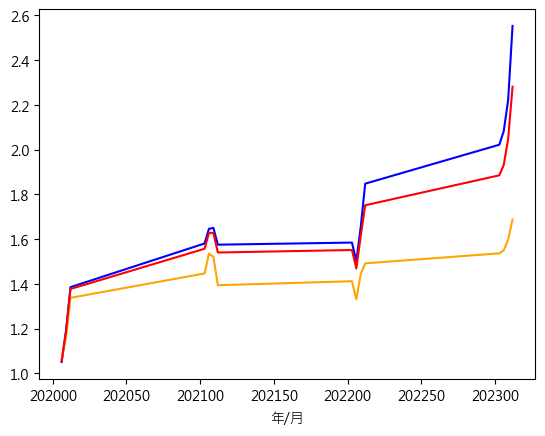

In [22]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  #顯示中文
(test_data[selected].groupby('年/月').mean()['累積季報酬率'] + 1).cumprod().plot(color = 'blue')     #randomforest
(test_data[~selected].groupby('年/月').mean()['累積季報酬率'] + 1).cumprod().plot(color = 'orange')  #benchmark1
(test_data.groupby('年/月').mean()['累積季報酬率'] + 1).cumprod().plot(color = 'red')                #benchmark2

#### Step6.進行特徵選取，找出比較有用的特徵

In [25]:
#看權重, 看那些特徵比較重要
feature_name = train_data.columns[:-1]
important = pd.Series(rf.feature_importances_, index = feature_name).sort_values(ascending=False)
important.head(20)

ROE(B)－常續利益    0.067980
ROE(A)－稅後      0.067623
每股盈餘           0.052837
稅前純益 /實收資本     0.044122
稀釋稅後淨利         0.036381
合併總損益          0.035255
季底每股稅後淨利       0.032970
加權平均股數－稀釋      0.031253
稅前淨利           0.030897
常續性稅後淨利        0.023617
ROA(A)稅後息前     0.023349
當季季底P/B        0.023242
營業利益           0.021211
營業利益 /實收資本比    0.021103
每股盈餘－完全稀釋      0.020024
季底每股稅前淨利       0.018692
每股營業利益         0.016620
  稅前淨利－CFO     0.016136
稅前淨利率          0.016112
歸屬母公司淨利（損）     0.015827
dtype: float64

#### Step7.找一棵樹畫出來看看

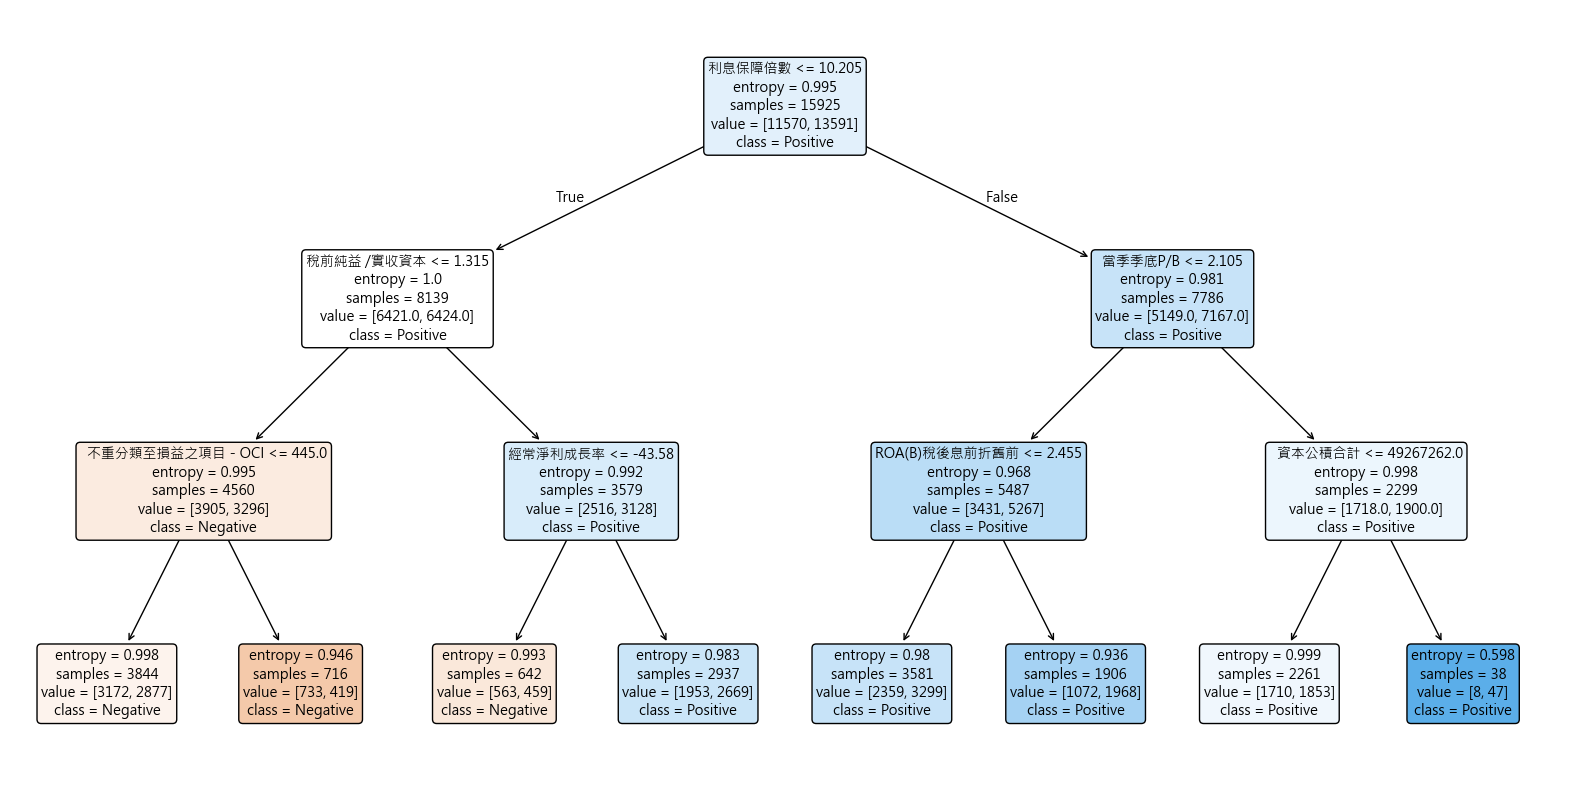

In [27]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 使用隨機森林的其中一棵樹
estimator = rf.estimators_[5]

# 畫出決策樹
plt.figure(figsize=(20, 10))
plot_tree(estimator, 
          feature_names=train_data.drop(columns='累積季報酬率').columns,
          class_names=['Negative', 'Positive'],
          filled=True, rounded=True, fontsize=10)
plt.show()